In [ ]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json
from nltk import PorterStemmer, bigrams as nltk_bigrams
from nltk.tokenize import MWETokenizer
import nltk
import re
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache
from wordcloud import WordCloud

sns.set_style("darkgrid")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

### Constants and function definitions

In [2]:
REVIEW_DATA_FILE = 'Movies_and_TV.jsonl'
META_DATA_FILE = "meta_Movies_and_TV.jsonl"

In [3]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

## 1. Data processing

### Process meta data

In [182]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map title
df_meta = df_meta.with_columns(
    pl.col("title")
      .str.replace(r"\[.*?\]", "", literal=False)
      .str.replace(r"\(.*?\)", "", literal=False)
      .str.strip_chars()
      .alias("title")
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

df_meta.limit(5)

title,average_rating,rating_number,description,price,categories,content_advisory,asin,desc_len
str,f64,i64,str,f64,list[str],list[str],str,u32
"""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",-1.0,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19
"""Ode to Joy: Beethoven's Sympho…",4.3,35,"""This special Ode to Joy: Beeth…",5.99,"[""Documentary""]",[],"""B01G9ILXXE""",234
"""Ben 10: Alien Force""",4.7,360,"""Itâ€™s hero time again for Ben…",24.49,"[""Science Fiction"", ""Comedy"", … ""Drama""]",[],"""B009SIYXDA""",377


In [5]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("desc_len"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
)

best_per_title.limit(5)

title,asins,average_rating,rating_number,description,desc_len,price,categories,content_advisory
str,list[str],f64,i64,str,u32,f64,list[str],list[str]
"""Vice""","[""B07LD4R4WT"", ""B07MNJ3JPP"", ""B07NRTDS2S""]",4.3,8137,"""Nominated for 8 Academy Awards…",538,9.99,"[""Movies & TV"", ""Studio Specials"", … ""All Fox Titles""]",[]
"""The Assassination of Jesse Jam…","[""B0012OVCF0""]",4.5,3584,"""The Assassination of Jesse Jam…",71,27.94,"[""Movies & TV"", ""Movies""]",[]
"""Castlerock: Season 1 [DVD] [20…","[""B07MFM43ZB""]",4.4,249,"""CASTLE ROCK takes viewers into…",814,18.79,"[""Movies & TV"", ""Studio Specials"", … ""All Titles""]",[]
"""The Maintenance Man [DVD]""","[""B000KGGZUI""]",4.8,187,"""As an expensive male escort, M…",623,20.0,"[""Movies & TV"", ""Genre for Featured Categories"", ""Comedy""]",[]
"""Carleton H. Sheets ~ How to Ge…","[""B000E14J5W""]",2.5,2,"""*** FROM CARLETON H. SHEETS IN…",392,2.95,"[""Movies & TV"", ""Movies""]",[]


### Process review data

In [6]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True)#.filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()
df.limit(5)

user_id,asin,rating,timestamp,text
str,str,f64,i64,str
"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""B013488XFS""",5.0,1440385637000,"""Amazon, please buy the show! I…"
"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""B00CB6VTDS""",5.0,1461100610000,"""My Kiddos LOVE this show!!"""
"""AG2L7H23R5LLKDKLBEF2Q3L2MVDA""","""B096Z8Z3R6""",3.0,1646271834582,"""Annabella Sciorra did her char…"
"""AG2L7H23R5LLKDKLBEF2Q3L2MVDA""","""B001H1SVZC""",5.0,1590639227074,"""...isn't always how you expect…"
"""AG2L7H23R5LLKDKLBEF2Q3L2MVDA""","""B06WVW16WY""",5.0,1586999747540,"""As you learn about the very un…"


In [7]:
df.height, df.get_column("asin").n_unique()

(13757796, 640455)

> All the asin with missing meta data

In [42]:
counts = (
    best_per_title
    .filter(pl.col("title").is_null())
    .explode("asins")
    .group_by("asins")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)
print(best_per_title.filter(pl.col("title").is_null()).get_column("asins")[0].n_unique())
counts

313988


asins,count
str,u32
"""B006GXBGIK""",1
"""B01MAYFYDA""",1
"""B00H2EODTQ""",1
"""B083H4ZFH3""",1
"""B097YZLX64""",1
…,…
"""B00OP7XJXO""",1
"""B08GZWYJV2""",1
"""B017VKTB5G""",1


In [9]:
asin_title_map = best_per_title.select([
    pl.col("title"),
    pl.col("asins"),
    pl.col("average_rating"),
    pl.col("price")
]).explode("asins").rename({"asins": "asin"})

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

In [13]:
# df.get_column("asin").n_unique(), df_meta.get_column("parent_asin").n_unique()
# asins_in_df = df.get_column("asin").unique()
# asins_in_meta = df_meta.get_column("asin").unique()

# missing_asins = asins_in_df.filter(~asins_in_df.is_in(asins_in_meta.implode()))
# missing_asins.len()

In [10]:
# def filter_reviews(df, movie_threshold=5, review_threshold=5):
#     prev_rows = -1
#     while df.height != prev_rows:
#         prev_rows = df.height
#         valid_movies = (
#             df.group_by('asin')
#             .agg(pl.col('user_id').n_unique().alias('count'))
#             .filter(pl.col('count') >= review_threshold)
#             .get_column('asin')
#         )
#         df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

#         valid_reviewers = (
#             df.group_by('user_id')
#             .agg(pl.col('asin').n_unique().alias('count'))
#             .filter(pl.col('count') >= movie_threshold)
#             .get_column('user_id')
#         )
#         df = df.filter(pl.col('user_id').is_in(valid_reviewers.implode()))
#     return df

# filtered_df = filter_reviews(df)
filtered_df = df_reviews.filter(pl.col("title").is_not_null())
print(filtered_df.height)
filtered_df.limit(5)

6252581


user_id,asin,rating,timestamp,text,title,average_rating,price
str,str,f64,i64,str,str,f64,f64
"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""B013488XFS""",5.0,1440385637000,"""Amazon, please buy the show! I…","""Sneaky Pete""",4.6,-1.0
"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""B00CB6VTDS""",5.0,1461100610000,"""My Kiddos LOVE this show!!""","""Creative Galaxy""",4.8,-1.0
"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""B0002J58ME""",5.0,1146713492000,"""This DVD was GREAT! I am a st…","""10 Minute Solution: Pilates""",4.6,8.77
"""AHITBJSS7KYUBVZPX7M2WJCOIVKQ""","""B079FLYB41""",5.0,1560014052867,"""Awesome movie! Must see.""","""Black Panther""",4.8,9.83
"""AHTTU2FL6FCNBBAESCJHOHHSSW7A""","""B01KBKKU7G""",4.0,1474051189000,"""It was pretty good. Had some p…","""Seven Girlfriends""",3.2,12.99


In [11]:
reviewer_counts = (
    filtered_df.group_by('user_id')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500)
).height

### Network

In [12]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('user_id')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = defaultdict(int)

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [13]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 2789341/2789341 [01:13<00:00, 38078.08it/s]


46872899

In [ ]:
thresholds = [2,3,4,5,7,10]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in movie_edgelist if w >= t]
    print(f"Edges with weight => {t}: {len(weighted_edges)}")

Edges with weight => 2: 2661798
Edges with weight => 3: 708469
Edges with weight => 4: 319490
Edges with weight => 5: 183420
Edges with weight => 7: 86234
Edges with weight => 10: 41881


In [48]:
Counter((w for _, _, w in movie_edgelist))

Counter({1: 44211101,
         2: 1953329,
         3: 388979,
         4: 136070,
         5: 62668,
         6: 34518,
         7: 20782,
         8: 13966,
         9: 9605,
         10: 7001,
         11: 5445,
         12: 4149,
         13: 3247,
         14: 2700,
         15: 2217,
         16: 1938,
         17: 1613,
         18: 1345,
         19: 1151,
         20: 1052,
         21: 902,
         22: 763,
         23: 659,
         24: 653,
         25: 509,
         27: 474,
         26: 438,
         28: 391,
         29: 362,
         30: 310,
         31: 298,
         32: 262,
         33: 237,
         34: 227,
         37: 186,
         35: 185,
         36: 171,
         38: 161,
         40: 160,
         39: 133,
         41: 129,
         42: 123,
         44: 116,
         43: 109,
         48: 93,
         46: 92,
         45: 86,
         52: 77,
         47: 74,
         56: 70,
         49: 66,
         51: 61,
         53: 60,
         58: 59,
         50:

### Graph

In [134]:
WEIGHT_THRESHOLD = 10
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

41881

In [92]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [135]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

In [136]:
len(G.nodes()), len(G.edges())

(14330, 41881)

In [138]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

5.845219818562456

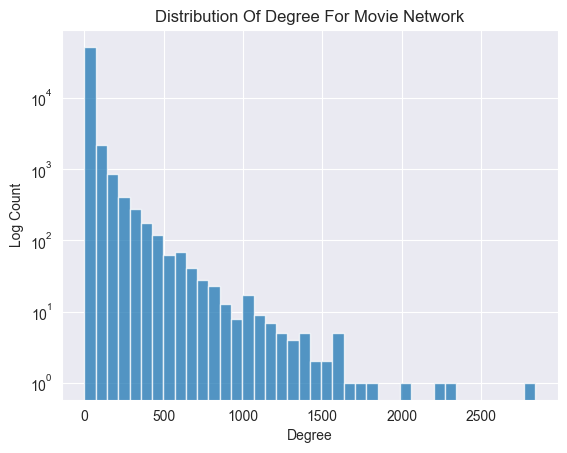

In [40]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75); 

### Community detection

In [28]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [ ]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False, resolution=1)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [154]:
communities = louvain_partitions(G)
len(communities)

2519

In [142]:
modularity(G, communities)

0.8733362938081917

Counter({2: 1273,
         3: 435,
         4: 234,
         5: 114,
         6: 94,
         7: 63,
         8: 51,
         9: 37,
         10: 29,
         12: 16,
         11: 15,
         13: 12,
         15: 9,
         16: 9,
         14: 7,
         17: 6,
         21: 6,
         28: 5,
         19: 5,
         18: 5,
         22: 5,
         20: 5,
         23: 4,
         42: 4,
         58: 4,
         40: 3,
         52: 3,
         25: 3,
         26: 3,
         32: 3,
         37: 3,
         57: 2,
         91: 2,
         38: 2,
         95: 2,
         24: 2,
         34: 2,
         30: 2,
         29: 2,
         31: 2,
         45: 2,
         103: 1,
         94: 1,
         122: 1,
         176: 1,
         118: 1,
         43: 1,
         49: 1,
         51: 1,
         106: 1,
         234: 1,
         84: 1,
         96: 1,
         171: 1,
         165: 1,
         116: 1,
         88: 1,
         101: 1,
         123: 1,
         108: 1,
         137: 1,
  

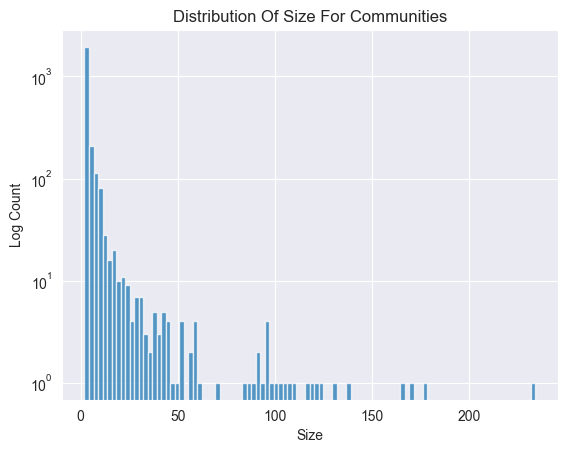

In [159]:
X = list(map(len, communities))
plt.yscale("log")
plt.title("Distribution Of Size For Communities")
plt.xlabel("Size")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

In [177]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price", "community"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

### Text analysis

In [144]:
all_asin = [asin for com in communities for asin in com]

In [145]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df.limit(2)

user_id,asin,rating,timestamp,text,title,average_rating,price,community
str,str,f64,i64,str,str,f64,f64,i64
"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""B013488XFS""",5.0,1440385637000,"""Amazon, please buy the show! I…","""Sneaky Pete""",4.6,-1.0,5
"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""B00CB6VTDS""",5.0,1461100610000,"""My Kiddos LOVE this show!!""","""Creative Galaxy""",4.8,-1.0,5


In [146]:
filtered_df.filter(pl.col("community").is_null()).height

1941499

In [ ]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null()) # Filter reviews that is not part of community - Removed with weight threshold

In [148]:
sum(list(map(len, communities))), len(G.nodes)

(14330, 14330)

In [ ]:
# size of each community
community_sizes = (
    filtered_df
    .group_by("community")
    .agg(pl.col("asin").n_unique().alias("community_size"))
    .sort("community_size", descending=True)
)

community_sizes.limit(10)

community,community_size
i64,u32
6,1111
3,912
5,378
27,324
13,275
35,193
41,180
44,163
46,152


In [162]:
filtered_df.filter(pl.col("community") == 175).select("title").unique()

title
str
"""She's All That"""
"""The Breakfast Club"""
"""Captain Ron"""
"""Don't Tell Mom the Babysitter'…"
"""The Buddy Holly Story/La Bamba"""
…
"""9 to 5 (Sexist, Egotistical, L…"
"""Can't Buy Me Love"""
"""Groundhog Day (Special 15th An…"


### Tokens

In [175]:
# Tokenize and stemming reviews
stemmer = PorterStemmer()
pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=10000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [cached_stem(t) for t in tokens] if stem else tokens

In [176]:
filtered_df = filtered_df.with_columns(
    pl.Series("tokens", (tokenize(x) for x in filtered_df["text"]))
)

In [133]:
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community
str,str,str,f64,i64,str,f64,f64,list[str],i64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd"", ""great"", … ""give""]",10
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife"", ""daughter"", … ""movi""]",8
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21


In [174]:
filtered_df = filtered_df.with_columns(
    pl.Series("bigrams", [list(nltk_bigrams(tokens)) for tokens in filtered_df["tokens"]])
)

ColumnNotFoundError: "tokens" not found

In [148]:
filtered_df.write_json("tokenizedReviews.json")
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community,bigrams
str,str,str,f64,i64,str,f64,f64,list[str],i64,list[list[str]]
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd"", ""great"", … ""give""]",10,"[[""dvd"", ""great""], [""great"", ""stay""], … [""love"", ""give""]]"
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12,"[[""grew"", ""one""], [""one"", ""couldnt""], … [""collect"", ""collect""]]"
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife"", ""daughter"", … ""movi""]",8,"[[""wife"", ""daughter""], [""daughter"", ""love""], … [""famili"", ""movi""]]"
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38,"[[""receiv"", ""yesterday""], [""yesterday"", ""chose""], … [""classic"", ""childhood""]]"
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21,"[[""subject"", ""movi""], [""movi"", ""review""], … [""attack"", ""opinion""]]"


In [149]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)
filtered_df = filtered_df.drop("bigrams")

In [ ]:
bigrams = (tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2)

In [151]:
bigram_counts = Counter(bigrams)
first_counts = Counter()
second_counts = Counter()
for (w1, w2), cnt in bigram_counts.items():
    first_counts[w1] += cnt
    second_counts[w2] += cnt

N = len(bigrams)
items = list(bigram_counts.items())
bgs, nii = zip(*items)
w1s, w2s = zip(*bgs)

f = np.fromiter((first_counts[w] for w in w1s), float)
s = np.fromiter((second_counts[w] for w in w2s), float)
o = np.array(nii, float)

nio = f - o
noi = s - o
noo = N - (o + nio + noi)

Eii = f * s / N
Eio = f * (N - s) / N
Eoi = (N - f) * s / N
Eoo = (N - f) * (N - s) / N

chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
p_vals = chi2.sf(chi2_vals, 1)

mask = (o > 50) & (p_vals < 0.001)
collocs = {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

In [152]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    pl.Series("tokens", (tokenizer.tokenize(tokens) for tokens in filtered_df["tokens"]))
)

In [153]:
filtered_df.limit(5)

asin,user_id,text,rating,timestamp,title,average_rating,price,tokens,community
str,str,str,f64,i64,str,f64,f64,list[str],i64
"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",5.0,1146713492000,"""10 Minute Solution: Pilates""",4.6,8.77,"[""dvd_great"", ""stay_home"", … ""give""]",10
"""B001JNNDRY""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",5.0,1364088518000,"""Columbo: Mystery Movie Collect…",4.7,13.4,"[""grew"", ""one"", … ""collect""]",12
"""B006OAXL92""","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""","""Wife and daughter loved the st…",4.0,1361833916000,"""Hugo (Blu-ray 3D + Blu-ray + D…",4.7,49.94,"[""wife_daughter"", ""love"", … ""famili_movi""]",8
"""B00JHH1ZN8""","""AHGAOIZVODNHYMNCBV4DECZH42UQ""","""she received hers yesterday i …",5.0,1551222425031,"""Rodgers & Hammerstein's Cinder…",4.9,6.99,"[""receiv"", ""yesterday"", … ""childhood""]",38
"""B0B6NHYWP9""","""AFZUK3MTBIBEDQOPAK3OATUOUKLA""","""Subjective movie review here..…",3.0,1665686687505,"""Beast""",4.1,14.99,"[""subject"", ""movi"", … ""opinion""]",21


In [169]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("num_reviews")
    ).sort("num_reviews", descending=True)
)
top5com = community_docs.limit(5)
top5com

ColumnNotFoundError: tokens

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["user_id", "asin", "rating", "timestamp", ...]; PROJECT */9 COLUMNS

In [155]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [156]:
idf = calculate_idf(community_docs)

In [173]:
top_5_tf_idf = {}

for _, row in top5com.iterrows():
    tf = calculate_tf(row["tokens"])
    tf_idf = calculate_tf_idf(tf, idf)
    top_5_tf_idf[row["community"]] = tf_idf

NameError: name 'idf' is not defined

### Word clouds

In [ ]:
def plot_word_clouds_grid(word_freq, top_movies = None, ncols=3):
    communities = list(word_freq.keys())
    nrows = -(-len(communities) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))
    axes = axes.flatten()

    for ax, comm in zip(axes, communities):
        cloud = WordCloud(background_color='white', height=500, width=500, colormap="viridis_r", contour_color='black', contour_width=0.5)
        cloud.generate_from_frequencies(word_freq[comm])
        movies = "\n".join(top_movies[comm]) if top_movies != None else str(comm)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title(movies, fontsize=12)
        ax.axis('off')

    for ax in axes[len(communities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds_grid(top_5_tf_idf) # Plotting is based on tf-idf values and stemmed tokens